In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/real_gdp.xlsx', sheet_name = 'data')
data = data.query('observation_date < 2020 & observation_date > 1959')
data = data.dropna().reset_index()

<ipython-input-3-8d6b67f75459>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['log'] = np.log(ts['level'])


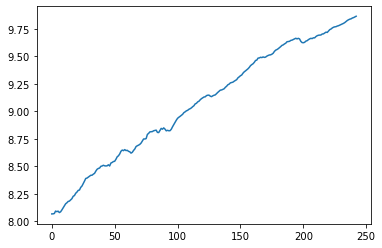

In [3]:
ts = data[['GDPC1']]
ts.columns = ['level']
ts['log'] = np.log(ts['level'])
ts['log'].plot()

# Build Models

# 1-step ahead AR(1) iterated

In [4]:
ts['log_dif'] = ts['log'].diff(1)
ts['4_ldif'] = ts['log'].diff(4)
ts = ts.dropna()

In [5]:
#Fit 1-step model
arma_model = ARIMA(ts['log_dif'], order=(1, 0, 0)).fit()
print(arma_model.summary())

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:                log_dif   No. Observations:                  239
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 825.707
Date:                Fri, 23 Oct 2020   AIC                          -1645.414
Time:                        15:33:40   BIC                          -1634.985
Sample:                             0   HQIC                         -1641.212
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0074      0.001     10.044      0.000       0.006       0.009
ar.L1          0.3220      0.055      5.829      0.000       0.214       0.430
sigma2      5.833e-05   3.76e-06     15.519      0.0

In [6]:
omega, rho, sigsq =  arma_model.params

year_mean = np.sum([omega*(4-i)*rho**i for i in range(0,4)])
year_rho = np.sum([rho**i for i in range(1,5)])
year_var = sigsq*np.sum( [  np.square(np.sum([rho**i for i in range(0,k)])) for k in range(1,5)])

In [7]:
ts['ar_4step_pred'] =  ( year_mean + year_rho*ts['log_dif']) + ts['log']
ts['ar_4step_pred'] = ts['ar_4step_pred'].shift(4)
ts

,level,log,log_dif,4_ldif,ar_4step_pred
4,3258.088,8.088896,-0.005408,0.020374,NaN
5,3274.029,8.093777,0.004881,0.024543,NaN
6,3232.009,8.080859,-0.012917,0.008779,NaN
7,3253.826,8.087587,0.006728,-0.006717,NaN
8,3309.059,8.104419,0.016832,0.015523,8.124766
...,...,...,...,...,...
238,18813.923,9.842352,0.003278,0.024454,9.860777
239,18950.347,9.849578,0.007225,0.022405,9.869939
240,19020.599,9.853278,0.003700,0.019441,9.875378
241,19141.744,9.859627,0.006349,0.020552,9.879946


0.13451051845129236

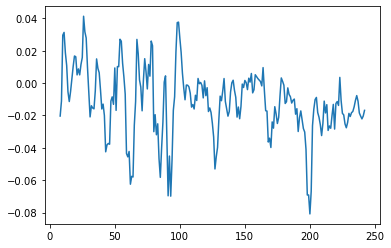

In [8]:
(ts['log']-ts['ar_4step_pred']).plot()
np.square((ts['log']-ts['ar_4step_pred'])).sum()

# "Direct Forecast" 

In [9]:
reg_df = ts[['4_ldif']]
reg_df[['year_lag']] = reg_df[['4_ldif']].shift(4)
reg_df = reg_df.dropna()

X = reg_df['year_lag'].values
Y = reg_df['4_ldif'].values
X = sm.add_constant(X)
direct_model = sm.OLS(Y,X)
results = direct_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     10.54
Date:                Fri, 23 Oct 2020   Prob (F-statistic):            0.00134
Time:                        15:33:40   Log-Likelihood:                 572.19
No. Observations:                 235   AIC:                            -1140.
Df Residuals:                     233   BIC:                            -1133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.002     10.149      0.0

C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
ts['4_ldif'] 

4      0.020374
5      0.024543
6      0.008779
7     -0.006717
8      0.015523
         ...   
238    0.024454
239    0.022405
240    0.019441
241    0.020552
242    0.023120
Name: 4_ldif, Length: 239, dtype: float64

In [11]:
alpha,beta = results.params
direct_sigsq = np.mean(np.square(results.resid))

ts['direct_pred'] = alpha + beta *ts['4_ldif']+ts['log']
ts['direct_pred'] = ts['direct_pred'].shift(4)

In [12]:
direct_sigsq

0.0004494075088313064

0.10561076457535747

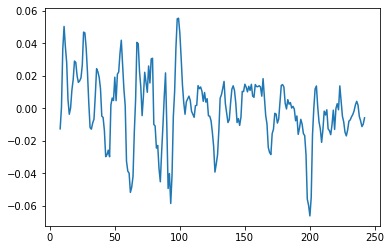

In [13]:
(ts['log']-ts['direct_pred']).plot()
np.square((ts['log']-ts['direct_pred'])).sum()

In [14]:
ts = ts.dropna()
ts['indirect_debias'] = ts['ar_4step_pred'] + (ts['log'] - ts['ar_4step_pred'] ).mean()
ts

<ipython-input-14-a45278bb29e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['indirect_debias'] = ts['ar_4step_pred'] + (ts['log'] - ts['ar_4step_pred'] ).mean()


,level,log,log_dif,4_ldif,ar_4step_pred,direct_pred,indirect_debias
8,3309.059,8.104419,0.016832,0.015523,8.124766,8.117032,8.112975
9,3372.581,8.123434,0.019014,0.029657,8.134480,8.122774,8.122689
10,3438.721,8.142855,0.019421,0.061996,8.113202,8.106601,8.101411
11,3500.054,8.160534,0.017679,0.072947,8.129158,8.110127,8.117367
12,3531.683,8.169530,0.008996,0.065111,8.150737,8.131553,8.138946
...,...,...,...,...,...,...,...
238,18813.923,9.842352,0.003278,0.024454,9.860777,9.847336,9.848987
239,18950.347,9.849578,0.007225,0.022405,9.869939,9.857360,9.858149
240,19020.599,9.853278,0.003700,0.019441,9.875378,9.864521,9.863587
241,19141.744,9.859627,0.006349,0.020552,9.879946,9.869341,9.868155


Text(0.5, 1.0, 'Residuals values')

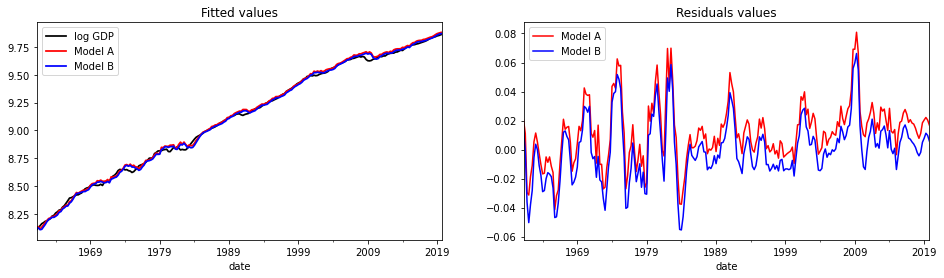

In [15]:
plot_ts = ts.copy()
plot_ts['date']= data.loc[8:]['observation_date']
plot_ts = plot_ts.set_index('date')
fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))

plot_ts[['log','ar_4step_pred','direct_pred']].plot(ax = axa, linewidth = 1.75, color = ['black','red','blue'])
axa.legend(['log GDP','Model A', 'Model B'])
axa.set_title('Fitted values')

plot_ts[['ar_4step_pred','direct_pred']].subtract(plot_ts['log'],axis= 0).plot(ax = axb, color = ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Residuals values')

# Compare Forecasts

# KS test for PITS

In [16]:
indirect_pits = []
direct_pits = []
indirect_debias_pits = []

for time in ts.index:
    actual = ts.loc[time,'log']
    
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
    indirect_bias = ts.loc[time,'indirect_debias']
    
    indirect_pits.append(scipy.stats.norm.cdf(actual, loc=ar_mean, scale=ar_std) )
    direct_pits.append(scipy.stats.norm.cdf(actual, loc=direct_mean, scale=direct_std) )
    indirect_debias_pits.append(scipy.stats.norm.cdf(actual, loc=indirect_bias, scale=ar_std) )
    
print(stats.kstest(indirect_pits, 'uniform'))
print(stats.kstest(direct_pits, 'uniform'))
print(stats.kstest(indirect_debias_pits, 'uniform'))

KstestResult(statistic=0.2453700574044328, pvalue=6.04686915389251e-13)
KstestResult(statistic=0.07977645765435473, pvalue=0.09509883795472995)
KstestResult(statistic=0.07343181685176672, pvalue=0.1508795932035305)


# KL Divergence

In [17]:
indirect_kl = 0
direct_kl = 0
indirect_debias_kl = 0


for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
    indirect_bias = ts.loc[time,'indirect_debias']

    indirect_kl = indirect_kl + scipy.stats.norm.logpdf(actual, loc=ar_mean, scale=ar_std)
    direct_kl = direct_kl + scipy.stats.norm.logpdf(actual, loc=direct_mean, scale=direct_std)
    indirect_debias_kl = indirect_debias_kl + scipy.stats.norm.logpdf(actual, loc=indirect_bias, scale=ar_std)

    
print(indirect_kl)
print(direct_kl)
print(indirect_debias_kl)

535.6129990763199
572.190152246374
576.1446116896918


# Coverage of all confidence intervals

In [18]:
coverage_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct','indirect_debias_pct']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    coverage_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
    indirect_bias = ts.loc[time,'indirect_debias']

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        ar_debias_ci = scipy.stats.norm.interval(prob, loc=indirect_bias, scale=ar_std)
        
        
        coverage_df.loc[prob] = coverage_df.loc[prob] + [1*(actual > ar_ci[0])*(actual<ar_ci[1]),
                                                           1*(actual > direct_ci[0])*(actual<direct_ci[1]),
                                                        1*(actual > ar_debias_ci[0])*(actual<ar_debias_ci[1])]
        
coverage_df = coverage_df.div(len(ts))
coverage_df['theoretical'] = prob_list

Text(0.5, 1.0, 'Scaled empirical Coverage Curve')

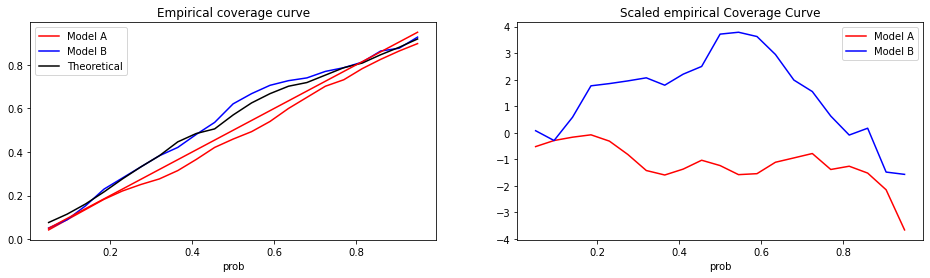

In [19]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
coverage_df.plot(ax = axa, color =  ['red','blue','black'] )
axa.legend(['Model A', 'Model B', 'Theoretical'])
axa.set_title('Empirical coverage curve')

coverage_df[['indirect_ar_pct','direct_pct']].subtract(prob_list, axis = 0).div(np.sqrt(prob_list*(1-prob_list)), axis = 0).multiply(np.sqrt(len(ts))).plot(ax = axb,color = ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Scaled empirical Coverage Curve')

In [20]:
print(np.square(coverage_df['indirect_ar_pct'] - coverage_df['theoretical']).sum())
print(np.square(coverage_df['direct_pct'] - coverage_df['theoretical']).sum())

0.025620303304662757
0.08608657763693978


# Interval forecast scores

In [21]:
def score(x,lower,upper,prob):
    return (upper-lower) + (2/(1-prob))*(max(x-upper,0) + max(lower-x,0))

In [22]:
score_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct','indirect_debias_pct']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    score_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )

    indirect_bias = ts.loc[time,'indirect_debias']

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        ar_debias_ci = scipy.stats.norm.interval(prob, loc=indirect_bias, scale=ar_std)

        
        score_df.loc[prob] = score_df.loc[prob] + [score(actual, ar_ci[0],ar_ci[1], prob),
                                                   score(actual, direct_ci[0], direct_ci[1], prob),
                                                  score(actual, ar_debias_ci[0],ar_debias_ci[1], prob)]
        
score_df = score_df.div(len(ts))

Text(0.5, 1.0, 'Interval forecast scores')

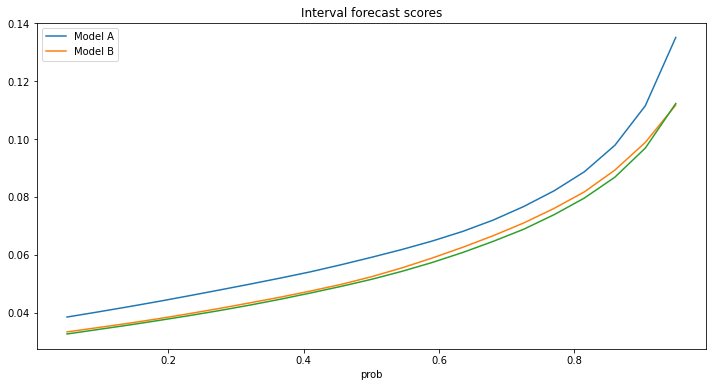

In [23]:
fig, ax = plt.subplots(figsize = (12,6))
score_df.plot(ax = ax)

ax.legend(['Model A','Model B'])
ax.set_title('Interval forecast scores')

In [24]:
print( ar_std, direct_std)

0.020075390247473023 0.0211992336850016


In [25]:
miss_df = pd.DataFrame(columns = ['prob','indirect_miss','indirect_length', 'direct', 'direct_length']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    miss_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        
        
        miss_df.loc[prob] = miss_df.loc[prob] + [max(actual - ar_ci[1],0) + max(ar_ci[0]-actual,0),
                                                 ar_ci[1]-ar_ci[0],
                                                 max(actual - direct_ci[1],0) + max(direct_ci[0]-actual,0),
                                                 direct_ci[1]-direct_ci[0] ]
        
miss_df = miss_df.div(len(ts))

In [26]:
miss_df

,indirect_miss,indirect_length,direct,direct_length
prob,,,,
0.050,0.017084,0.002518,0.014575,0.002659
0.095,0.016029,0.004792,0.013463,0.005060
0.140,0.015017,0.007082,0.012394,0.007478
0.185,0.014047,0.009395,0.011399,0.009920
0.230,0.013118,0.011739,0.010483,0.012396
0.275,0.012210,0.014124,0.009615,0.014915
0.320,0.011313,0.016561,0.008797,0.017488
0.365,0.010437,0.019060,0.008005,0.020127
0.410,0.009581,0.021635,0.007263,0.022846


Text(0.5, 1.0, 'Aveage length of interval')

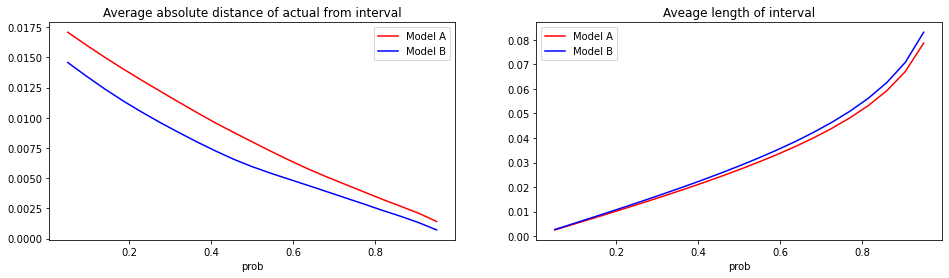

In [27]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
miss_df[['indirect_miss','direct']].plot(ax = axa, color =  ['red','blue'] )
axa.legend(['Model A', 'Model B'])
axa.set_title('Average absolute distance of actual from interval')

miss_df[['indirect_length','direct_length']].plot(ax = axb, color =  ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Aveage length of interval')

# Transition Matrix testing:

In [46]:
ts['indirect_ci_markov'] = 0
ts['direct_ci_markov'] = 0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_4step_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
            
    for prob in test_probs:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        
        ts.loc[time, 'indirect_ci_markov'] = ts.loc[time, 'indirect_ci_markov'] + 1*(actual > ar_ci[0])*(actual<ar_ci[1])
        ts.loc[time, 'direct_ci_markov'] = ts.loc[time, 'direct_ci_markov'] + 1*(actual > direct_ci[0])*(actual<direct_ci[1])

<ipython-input-46-b0e6ec837307>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['indirect_ci_markov'] = 0
<ipython-input-46-b0e6ec837307>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['direct_ci_markov'] = 0
C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [62]:
direct_table = pd.DataFrame( columns = range(0,4))
for index in range(0,4):
    direct_table.loc[index]=0

for time in range(ts.index.min(), len(ts)):
    val = ts.loc[time,'direct_ci_markov']
    new_val = ts.loc[time+1,'direct_ci_markov']
    
    direct_table.loc[val,new_val] = direct_table.loc[val,new_val] +1
    
direct_table

,0,1,2,3
0,19,5,4,1
1,4,7,5,6
2,2,6,10,20
3,4,4,19,111


In [63]:
indirect_table = pd.DataFrame( columns = range(0,4))
for index in range(0,4):
    indirect_table.loc[index]=0

for time in range(ts.index.min(), len(ts)):
    val = ts.loc[time,'indirect_ci_markov']
    new_val = ts.loc[time+1,'indirect_ci_markov']
    
    indirect_table.loc[val,new_val] = indirect_table.loc[val,new_val] +1
    
indirect_table

,0,1,2,3
0,24,6,2,1
1,3,14,10,6
2,4,7,22,23
3,2,6,21,76
